In [1]:
%matplotlib widget

import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

import seaborn as sns

sns.set(context="talk", style="ticks", color_codes=True)


In [2]:
# read MaNGA examples
# extract sky spectra from blue and red channels
# plot both channel spectra
# outline sky spectra cleaning: fiber masking, pixel masking, outliers
# separate continuum from emission lines

# examples path
manga_path = "/disk-a/mejia/Research/UNAM/lvm-drp/lvmdrp/docs/nb/_data-manga"

filenames = sorted(os.listdir(manga_path))
filenames

['mgSFrame-b1-00198570.fits.gz', 'mgSFrame-r1-00198570.fits.gz']

In [3]:
blue_sky_path = os.path.join(manga_path, filenames[0])
blue_sky = fits.open(blue_sky_path)

blue_sky.info()

Filename: /disk-a/mejia/Research/UNAM/lvm-drp/lvmdrp/docs/nb/_data-manga/mgSFrame-b1-00198570.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     190   ()      
  1  FLUX          1 ImageHDU       194   (4112, 709)   float32   
  2  IVAR          1 ImageHDU        10   (4112, 709)   float32   
  3  MASK          1 ImageHDU        10   (4112, 709)   int32   
  4  WSET          1 BinTableHDU     30   1R x 4C   [8A, D, D, 4254D]   
  5  LSFPOST       1 ImageHDU        10   (4112, 709)   float32   
  6  LSFPRE        1 ImageHDU        10   (4112, 709)   float32   
  7  SLITMAP       1 BinTableHDU     86   1423R x 34C   [12A, J, J, 8A, J, J, 8A, J, J, J, E, J, K, J, 5A, J, 3A, J, J, J, D, D, D, D, D, D, E, E, E, J, J, J, 5E, 8A]   
  8  XPOS          1 ImageHDU        10   (4112, 709)   float32   
  9  SUPERFLAT     1 ImageHDU        10   (4112, 709)   float32   
 10  AIRSET        1 BinTableHDU     30   1R x 4C   [8A, D, D, 4254D]   
 1

In [4]:
red_sky_path = os.path.join(manga_path, filenames[1])
red_sky = fits.open(red_sky_path)

red_sky.info()

Filename: /disk-a/mejia/Research/UNAM/lvm-drp/lvmdrp/docs/nb/_data-manga/mgSFrame-r1-00198570.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     190   ()      
  1  FLUX          1 ImageHDU       194   (4128, 709)   float32   
  2  IVAR          1 ImageHDU        10   (4128, 709)   float32   
  3  MASK          1 ImageHDU        10   (4128, 709)   int32   
  4  WSET          1 BinTableHDU     36   1R x 7C   [8A, D, D, 4254D, E, E, E]   
  5  LSFPOST       1 ImageHDU        10   (4128, 709)   float32   
  6  LSFPRE        1 ImageHDU        10   (4128, 709)   float32   
  7  SLITMAP       1 BinTableHDU     86   1423R x 34C   [12A, J, J, 8A, J, J, 8A, J, J, J, E, J, K, J, 5A, J, 3A, J, J, J, D, D, D, D, D, D, E, E, E, J, J, J, 5E, 8A]   
  8  XPOS          1 ImageHDU        10   (4128, 709)   float32   
  9  SUPERFLAT     1 ImageHDU        10   (4128, 709)   float32   
 10  AIRSET        1 BinTableHDU     36   1R x 7C   [8A, D, D, 425

In [5]:
import pandas as pd
from io import StringIO

from enum import IntFlag


manga_2d_bitmask_table = StringIO("""<table class="table table-condensed table-bordered">
<thead>
<tr>
<th>Bit name</th>
<th>Binary digit</th>
<th>Value</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td colspan="4"><i>The following mask bits are for fibers:</i></td>
</tr>
<tr>
<td>NOPLUG</td>
<td class="text-left">0</td>
<td class="text-left">1</td>
<td>Fiber not listed in plugmap file.</td>
</tr>
<tr>
<td>BADTRACE</td>
<td class="text-left">1</td>
<td class="text-left">2</td>
<td>Bad trace.</td>
</tr>
<tr>
<td>BADFLAT</td>
<td class="text-left">2</td>
<td class="text-left">4</td>
<td>Low counts in fiberflat.</td>
</tr>
<tr>
<td>BADARC</td>
<td class="text-left">3</td>
<td class="text-left">8</td>
<td>Bad arc solution.</td>
</tr>
<tr>
<td>MANYBADCOLUMNS</td>
<td class="text-left">4</td>
<td class="text-left">16</td>
<td>More than 10% of pixels are bad columns.</td>
</tr>
<tr>
<td>MANYREJECTED</td>
<td class="text-left">5</td>
<td class="text-left">32</td>
<td>More than 10% of pixels are rejected in extraction.</td>
</tr>
<tr>
<td>LARGESHIFT</td>
<td class="text-left">6</td>
<td class="text-left">64</td>
<td>Large spatial shift between flat and object position.</td>
</tr>
<tr>
<td>BADSKYFIBER</td>
<td class="text-left">7</td>
<td class="text-left">128</td>
<td>Sky fiber shows extreme residuals.</td>
</tr>
<tr>
<td>NEARWHOPPER</td>
<td class="text-left">8</td>
<td class="text-left">256</td>
<td>Within 2 fibers of a whopping fiber (exclusive).</td>
</tr>
<tr>
<td>WHOPPER</td>
<td class="text-left">9</td>
<td class="text-left">512</td>
<td>Whopping fiber, with a very bright source.</td>
</tr>
<tr>
<td>SMEARIMAGE</td>
<td class="text-left">10</td>
<td class="text-left">1024</td>
<td>Smear available for red and blue cameras.</td>
</tr>
<tr>
<td>SMEARHIGHSN</td>
<td class="text-left">11</td>
<td class="text-left">2048</td>
<td>S/N sufficient for full smear fit.</td>
</tr>
<tr>
<td>SMEARMEDSN</td>
<td class="text-left">12</td>
<td class="text-left">4096</td>
<td>S/N only sufficient for scaled median fit.</td>
</tr>
<tr>
<td>DEADFIBER</td>
<td class="text-left">13</td>
<td class="text-left">8192</td>
<td>Broken fiber according to metrology files.</td>
</tr>
<tr>
<td colspan="4"><i>The following mask bits are for a pixel:</i></td>
</tr>
<tr>
<td>SATURATION</td>
<td class="text-left">14</td>
<td class="text-left">16384</td>
<td>Pixel considered saturated.</td>
</tr>
<tr>
<td>BADPIX</td>
<td class="text-left">15</td>
<td class="text-left">32768</td>
<td>Pixel flagged in badpix reference file.</td>
</tr>
<tr>
<td>COSMIC</td>
<td class="text-left">16</td>
<td class="text-left">65536</td>
<td>Pixel flagged as cosmic ray.</td>
</tr>
<tr>
<td>NEARBADPIXEL</td>
<td class="text-left">17</td>
<td class="text-left">131072</td>
<td>Bad pixel within 3 pixels of trace.</td>
</tr>
<tr>
<td>LOWFLAT</td>
<td class="text-left">18</td>
<td class="text-left">262144</td>
<td>Flat field less than 0.5.</td>
</tr>
<tr>
<td>FULLREJECT</td>
<td class="text-left">19</td>
<td class="text-left">524288</td>
<td>Pixel fully rejected in extraction model fit (INVVAR=0).</td>
</tr>
<tr>
<td>PARTIALREJECT</td>
<td class="text-left">20</td>
<td class="text-left">1048576</td>
<td>Some pixels rejected in extraction model fit.</td>
</tr>
<tr>
<td>SCATTEREDLIGHT</td>
<td class="text-left">21</td>
<td class="text-left">2097152</td>
<td>Scattered light significant.</td>
</tr>
<tr>
<td>CROSSTALK</td>
<td class="text-left">22</td>
<td class="text-left">4194304</td>
<td>Cross-talk significant.</td>
</tr>
<tr>
<td>NOSKY</td>
<td class="text-left">23</td>
<td class="text-left">8388608</td>
<td>Sky level unknown at this wavelength (INVVAR=0).</td>
</tr>
<tr>
<td>BRIGHTSKY</td>
<td class="text-left">24</td>
<td class="text-left">16777216</td>
<td>Sky level &gt; flux + 10*(flux_err) AND sky &gt; 1.25 * median(sky,99 pixels).</td>
</tr>
<tr>
<td>NODATA</td>
<td class="text-left">25</td>
<td class="text-left">33554432</td>
<td>No data available in combine B-spline (INVVAR=0).</td>
</tr>
<tr>
<td>COMBINEREJ</td>
<td class="text-left">26</td>
<td class="text-left">671108864</td>
<td>Rejected in combine B-spline.</td>
</tr>
<tr>
<td>BADFLUXFACTOR</td>
<td class="text-left">27</td>
<td class="text-left">134217728</td>
<td>Low flux-calibration or flux-correction factor.</td>
</tr>
<tr>
<td>BADSKYCHI</td>
<td class="text-left">28</td>
<td class="text-left">268435456</td>
<td>Relative chi2 &gt; 3 in sky residuals at this wavelength.</td>
</tr>
<tr>
<td>REDMONSTER</td>
<td class="text-left">29</td>
<td class="text-left">536870912</td>
<td>Contiguous region of bad chi2 in sky residuals (with threshhold of relative chi2 &gt; 3).</td>
</tr>
<tr>
<td>3DREJECT</td>
<td class="text-left">30</td>
<td class="text-left">1073741824</td>
<td>Used in RSS file, indicates should be rejected when making 3D cube.</td>
</tr>
</tbody>
</table>""")

bmask_table = pd.read_html(manga_2d_bitmask_table)[0].rename(columns=lambda name: name.replace(" ", "_"))
bmask_table = bmask_table.drop(index=[0,15]).reset_index(drop=True)
bmask_table

class MaNGABitmask(IntFlag):
    NOPLUG  = 1
    BADTRACE  = 2
    BADFLAT  = 4
    BADARC  = 8
    MANYBADCOLUMNS  = 16
    MANYREJECTED  = 32
    LARGESHIFT  = 64
    BADSKYFIBER  = 128
    NEARWHOPPER  = 256
    WHOPPER  = 512
    SMEARIMAGE  = 1024
    SMEARHIGHSN  = 2048
    SMEARMEDSN  = 4096
    DEADFIBER  = 8192
    SATURATION  = 16384
    BADPIX  = 32768
    COSMIC  = 65536
    NEARBADPIXEL  = 131072
    LOWFLAT  = 262144
    FULLREJECT  = 524288
    PARTIALREJECT  = 1048576
    SCATTEREDLIGHT  = 2097152
    CROSSTALK  = 4194304
    NOSKY  = 8388608
    BRIGHTSKY  = 16777216
    NODATA  = 33554432
    COMBINEREJ  = 671108864
    BADFLUXFACTOR  = 134217728
    BADSKYCHI  = 268435456
    REDMONSTER  = 536870912
    _3DREJECT  = 1073741824

In [6]:
blue_ipix, blue_fpix = int(blue_sky["AIRSET"].data[0]["XMIN"]), int(blue_sky["AIRSET"].data[0]["XMAX"])
red_ipix, red_fpix = int(red_sky["AIRSET"].data[0]["XMIN"]), int(red_sky["AIRSET"].data[0]["XMAX"])
nsed, blue_ncoef, blue_nwav = *blue_sky["AIRSET"].data["COEFF"][0].shape, blue_fpix-blue_ipix+1
nsed, red_ncoef, red_nwav = *red_sky["AIRSET"].data["COEFF"][0].shape, red_fpix-red_ipix+1
blue_wave_rss = np.zeros((nsed, blue_nwav))
red_wave_rss = np.zeros((nsed, red_nwav))
for ised in range(nsed):
    blue_poly = np.polynomial.Legendre(blue_sky["AIRSET"].data["COEFF"][0][ised], domain=(blue_ipix,blue_fpix))
    blue_wave_rss[ised] = 10**blue_poly(np.arange(blue_ipix, blue_fpix+1))
    
    red_poly = np.polynomial.Legendre(red_sky["AIRSET"].data["COEFF"][0][ised], domain=(red_ipix,red_fpix))
    red_wave_rss[ised] = 10**red_poly(np.arange(red_ipix, red_fpix+1))

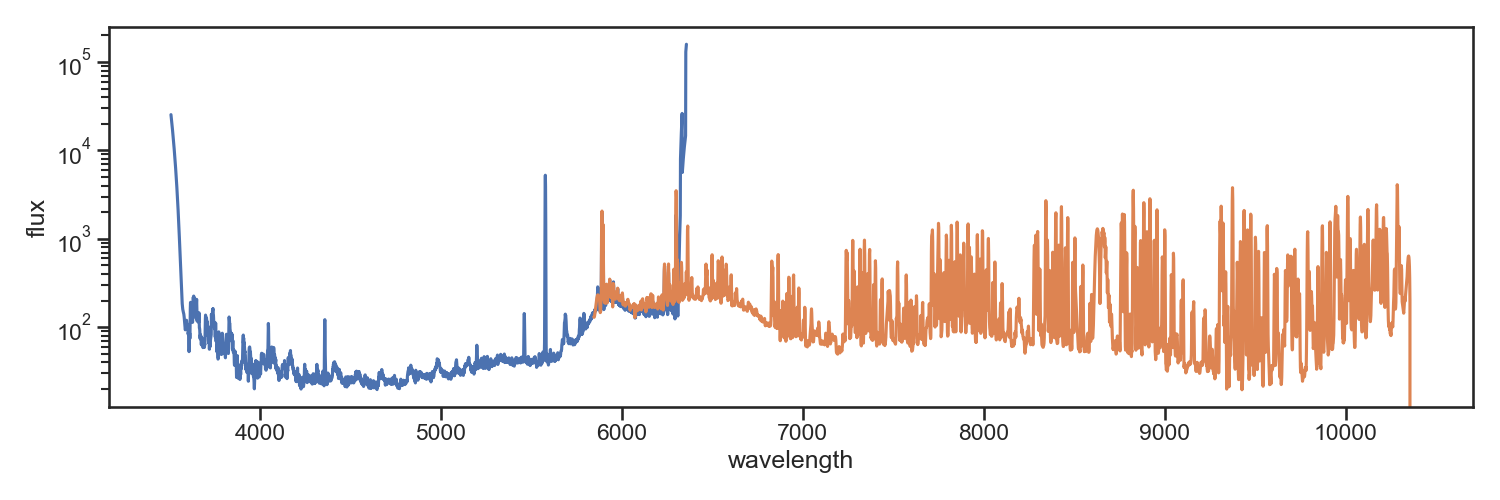

In [7]:
ised = 600

blue_mask = blue_sky["MASK"].data[ised] == 0
red_mask = red_sky["MASK"].data[ised] == 0


plt.figure(figsize=(15,5))
plt.semilogy(blue_wave_rss[ised][blue_mask], blue_sky["SKY"].data[ised][blue_mask])
plt.semilogy(red_wave_rss[ised][red_mask], red_sky["SKY"].data[ised][red_mask])
plt.xlabel("wavelength")
plt.ylabel("flux")
plt.tight_layout()


In [8]:
from lvmdrp.core.spectrum1d import Spectrum1D


blue_sed = Spectrum1D(
    wave=blue_wave_rss[ised],
    data=blue_sky["SKY"].data[ised],
    error=np.divide(1, np.sqrt(blue_sky["IVAR"].data[ised]), where=blue_sky["IVAR"].data[ised] > 0, out=1e12*np.ones(blue_sky["SKY"].data.shape[1])),
    mask=blue_sky["MASK"].data[ised] != 0,
    inst_fwhm=blue_sky["LSFPOST"].data[ised]
)
red_sed = Spectrum1D(
    wave=red_wave_rss[ised],
    data=red_sky["SKY"].data[ised],
    error=np.divide(1, np.sqrt(red_sky["IVAR"].data[ised]), where=red_sky["IVAR"].data[ised] > 0, out=1e12*np.ones(red_sky["SKY"].data.shape[1])),
    mask=red_sky["MASK"].data[ised] != 0,
    inst_fwhm=red_sky["LSFPOST"].data[ised]
)

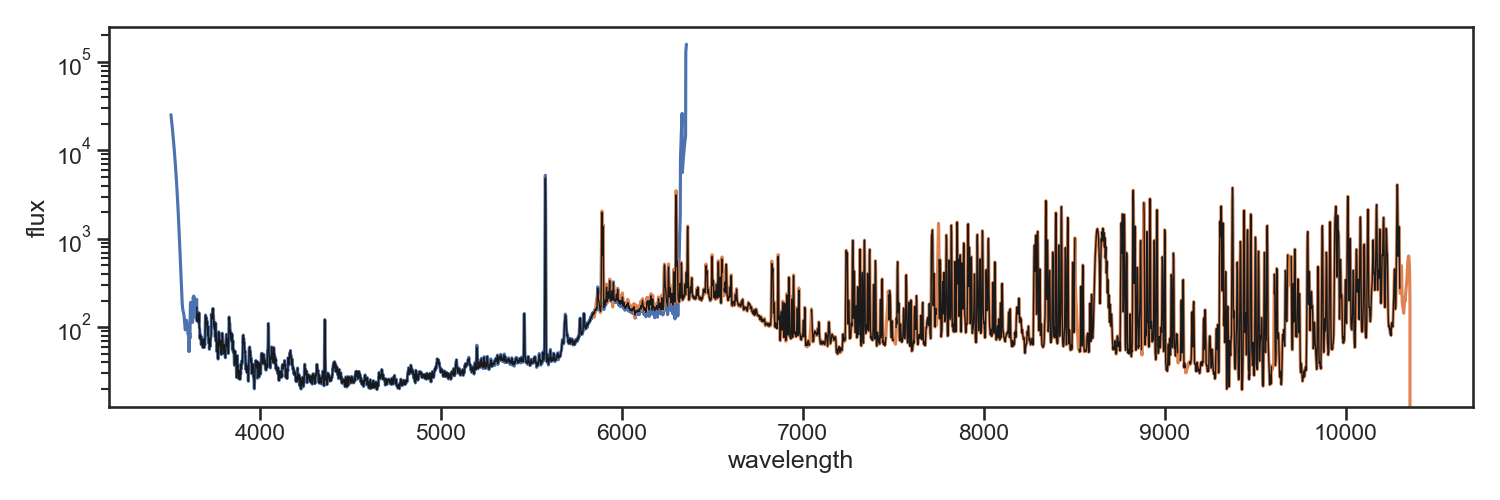

In [12]:
plt.figure(figsize=(15,5))
plt.semilogy(blue_sed._wave[~blue_sed._mask], blue_sed._data[~blue_sed._mask])
plt.semilogy(red_sed._wave[~red_sed._mask], red_sed._data[~red_sed._mask])

joint_sky = blue_sed.coaddSpec(red_sed)
wl_mask = (joint_sky._wave >= 3650) & (joint_sky._wave <= 10300)
joint_sky = Spectrum1D(
    wave=joint_sky._wave[wl_mask],
    data=joint_sky._data[wl_mask],
    mask=joint_sky._mask[wl_mask],
    inst_fwhm=joint_sky._inst_fwhm[wl_mask]
)

plt.semilogy(joint_sky._wave, joint_sky._data, color="k", lw=1)

plt.xlabel("wavelength")
plt.ylabel("flux")
plt.tight_layout()


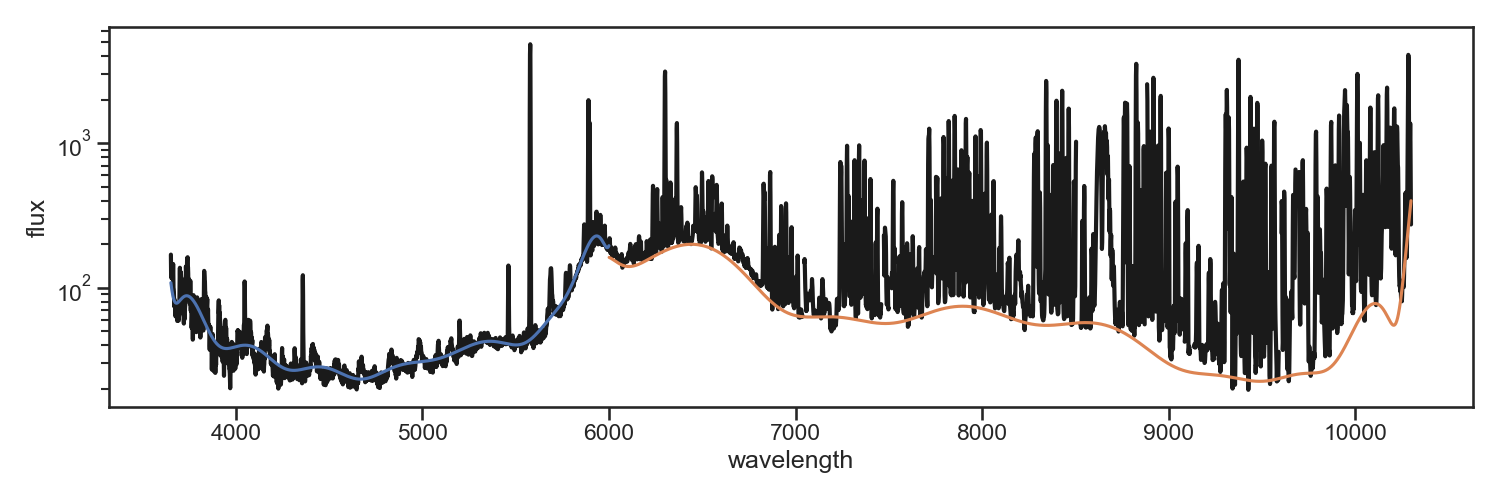

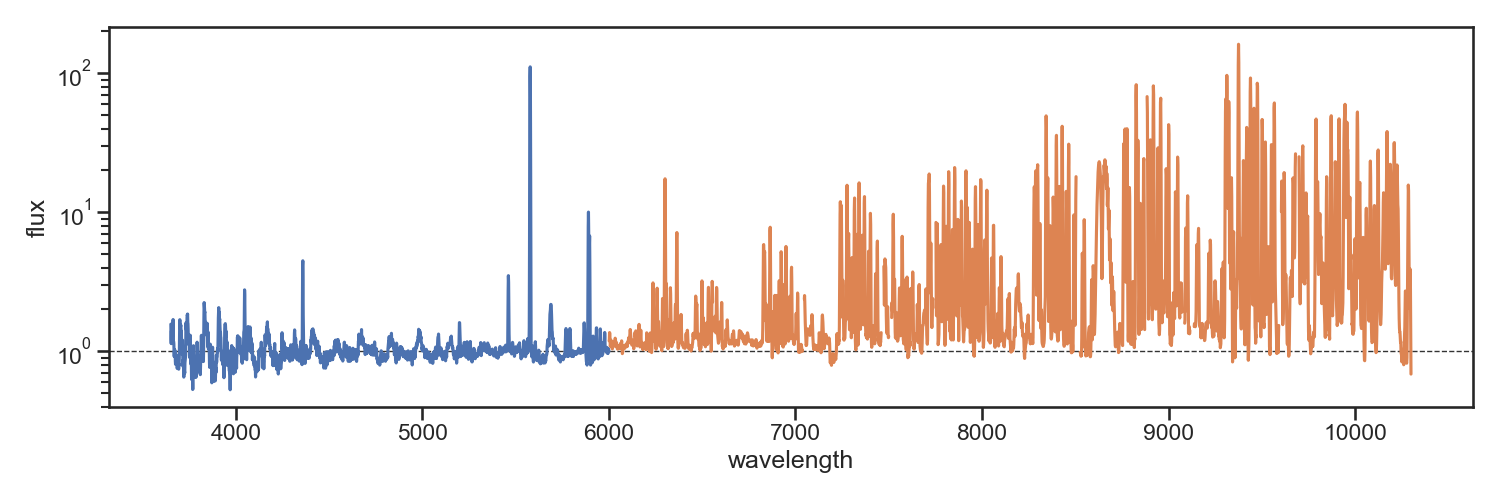

In [14]:
# sources:
# NIR sky emission: https://www.researchgate.net/publication/234230583_Night-sky_spectral_atlas_of_OH_emission_lines_in_the_near-infrared


from specutils.fitting import fit_generic_continuum
from specutils import Spectrum1D as Spec1D, SpectralRegion
from specutils.manipulation import extract_region
from astropy import units as u
from astropy.modeling import models
from astropy.modeling import fitting
from scipy.stats import binned_statistic


sky_sed = Spec1D(flux=joint_sky._data*u.erg/u.s/u.cm**2/u.AA, spectral_axis=joint_sky._wave*u.AA)

b_mask = joint_sky._wave<=6000
r_mask = joint_sky._wave>6000

blue = extract_region(sky_sed, region=SpectralRegion(0*u.AA, 6000*u.AA))
red = extract_region(sky_sed, region=SpectralRegion(6000*u.AA, 90000*u.AA))

min, xe, _ = binned_statistic(
    x=red.wavelength,
    values=red.flux,
    statistic=np.min,
    bins=np.logspace(
        start=np.log10(red.wavelength.value.min()),
        stop=np.log10(red.wavelength.value.max()),
        num=50
    )
)
xbin = (xe[1:] + xe[:-1])/2

red_bin = Spec1D(flux=min*u.erg/u.s/u.cm**2/u.AA, spectral_axis=xbin*u.AA)

# plt.figure(figsize=(20, 5))
# plt.semilogy(red.wavelength, red.flux)
# plt.semilogy(xbin, min, "ok")

blue_cont = fit_generic_continuum(
    spectrum=blue,
    model=models.Legendre1D(20),
    median_window=31,
    fitter=fitting.LinearLSQFitter()
)
red_cont = fit_generic_continuum(
    spectrum=red_bin,
    model=models.Legendre1D(20),
    median_window=1,
    fitter=fitting.LinearLSQFitter()
)

plt.figure(figsize=(15, 5))
plt.semilogy(sky_sed.wavelength, sky_sed.flux, color="k", lw=3)
plt.semilogy(blue.wavelength, blue_cont(blue.wavelength))
plt.semilogy(red.wavelength, red_cont(red.wavelength))
plt.xlabel("wavelength")
plt.ylabel("flux")
plt.tight_layout()

plt.figure(figsize=(15, 5))
plt.axhline(1, ls="--", lw=1, color="0.2")
plt.semilogy(blue.wavelength, blue.flux/blue_cont(blue.wavelength))
plt.semilogy(red.wavelength, red.flux/red_cont(red.wavelength))
plt.xlabel("wavelength")
plt.ylabel("flux")
plt.tight_layout()


In [ ]:
# build iterative way of removing sky continuum by lowering the polynomial degree in each step
# take into account line blending
# library of ESO sky: airglow, cont and atm transmission only
#   skycorr: https://github.com/ryanhoughton/PySkyCorr
#   skycalc: https://www.eso.org/observing/etc/doc/skycalc/helpskycalccli.html
